In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy import dtype
from sklearn.datasets import make_circles

In [3]:
n_samples = 1000
X,y = make_circles(n_samples=n_samples,
                   noise=0.03,
                   random_state=42)
X.shape, y.shape

((1000, 2), (1000,))

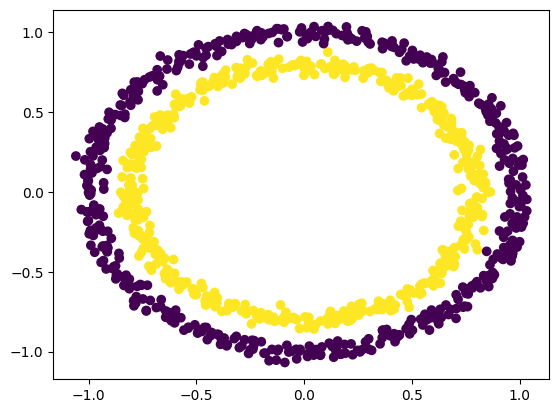

sending cmd -->    CMD_THREAD_CREATE <xml><thread name="Thread-9" id="pid_22799_id_139855687825584" /></xml>


In [4]:

df = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"y":y[:]})
plt.scatter(x = df["X1"], y = df["X2"], c=y)

In [5]:
#handling the shape issues:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [6]:
pd.DataFrame(X,y)

,0,1
1,0.754246,0.231481
1,-0.756159,0.153259
1,-0.815392,0.173282
1,-0.393731,0.692883
0,0.442208,-0.896723
...,...,...
0,0.244054,0.944125
0,-0.978655,-0.272373
1,-0.136900,-0.810012
0,0.670362,-0.767502


In [7]:
import torch
type(X)
X = torch.from_numpy(X)
y = torch.from_numpy(y)
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [8]:

#split training and test data:
split_percentage = 0.9
train_split = int(split_percentage * len(X))
X_train,y_train, X_test, y_test  = X[:train_split], y[:train_split], X[train_split:], y[train_split:]
print(f"Shape for train set: {X_train.shape} and label : {y_train.shape}")
print(f"Shape for test set: {X_test.shape} and label:{y_test.shape}")

Shape for train set: torch.Size([900, 2]) and label : torch.Size([900])
Shape for test set: torch.Size([100, 2]) and label:torch.Size([100])


In [9]:
#building the neural net:
from torch import nn


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(42)

class CircleModelV0(nn.Module):
    def __init__(self):
        super(CircleModelV0, self).__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # layer_1_logits = self.relu(self.layer_1(x))
        # layer_2_logits = self.relu(self.layer_2(layer_1_logits))
        # logits = self.layer_3(layer_2_logits)
        return self.sigmoid(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))

cuda


In [10]:
torch.manual_seed(42)
model_0 = CircleModelV0().to(device)
print(f"layer_1.weight: {model_0.state_dict()['layer_1.weight'].shape}")

print(f"layer_2.weight: {model_0.state_dict()['layer_2.weight'].shape}")
model_0.state_dict()

layer_1.weight: torch.Size([10, 2])
layer_2.weight: torch.Size([10, 10])


OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [11]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1),
).to(device)
print(f"layer_1.weight: {model_1.state_dict()['0.weight'].shape}")

print(f"layer_2.weight: {model_1.state_dict()['1.weight'].shape}")

layer_1.weight: torch.Size([5, 2])
layer_2.weight: torch.Size([1, 5])


In [12]:
#untrained preds:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device,dtype=torch.float))
print(untrained_preds.shape, y_test.shape)
print(untrained_preds[:10].squeeze())
print(y_test[:10])


torch.Size([100, 1]) torch.Size([100])
tensor([0.5052, 0.5105, 0.5018, 0.5031, 0.5043, 0.5050, 0.5024, 0.5093, 0.5031,
        0.5026], device='cuda:0')
tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 0])


In [13]:
#cost function
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)

In [14]:
#accuracy metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    #print(f"{correct} out of {len(y_pred)} samples correct")
    return  correct / len(y_true)
    

In [15]:
torch.eq(y_test,untrained_preds.cpu()).sum().item() / len(y_test)

0.0

In [16]:
# accuracy_fn(y_test.cpu(), untrained_preds)

In [18]:
#train_model:
epochs = 1500
train_losses = []
test_losses = []
train_accs = []
test_accs = []
torch.manual_seed(42)

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train.to(device,dtype=torch.float)).squeeze()
    loss = loss_fn(y_logits, y_train.to(device,dtype=torch.float))
    preds = torch.round(torch.sigmoid(y_logits))
    train_losses.append(loss.cpu().detach().numpy())
    train_accuracy = accuracy_fn(y_true=y_train.to(device),y_pred=preds)
    train_accs.append(train_accuracy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #inference mode:
    model_0.eval()
    with torch.inference_mode():
        test_y_logits = model_0(X_test.to(device,dtype=torch.float)).squeeze()
        test_loss = loss_fn(test_y_logits, y_test.to(device,dtype=torch.float))
        test_pred = torch.round(test_y_logits)
        test_losses.append(test_loss.cpu().detach().numpy())
        test_accuracy = accuracy_fn(y_true=y_test.to(device),y_pred=test_pred)
        test_accs.append(test_accuracy)
    if epoch % 10 == 0:
        print(f"Epoch:{epoch}| Train Loss: {loss:.6f} |Train Acc:{train_accuracy:.4f} | Test Loss: {test_loss:.6f} |Test Acc:{test_accuracy:.4f}")
         

Epoch:0| Train Loss: 0.639509 |Train Acc:0.5067 | Test Loss: 0.662941 |Test Acc:0.6600
Epoch:10| Train Loss: 0.635196 |Train Acc:0.5067 | Test Loss: 0.659757 |Test Acc:0.6800
Epoch:20| Train Loss: 0.630717 |Train Acc:0.5067 | Test Loss: 0.655949 |Test Acc:0.7000
Epoch:30| Train Loss: 0.626050 |Train Acc:0.5067 | Test Loss: 0.651887 |Test Acc:0.7400
Epoch:40| Train Loss: 0.621379 |Train Acc:0.5067 | Test Loss: 0.648092 |Test Acc:0.7700
Epoch:50| Train Loss: 0.616809 |Train Acc:0.5067 | Test Loss: 0.644248 |Test Acc:0.8100
Epoch:60| Train Loss: 0.612351 |Train Acc:0.5067 | Test Loss: 0.640203 |Test Acc:0.8500
Epoch:70| Train Loss: 0.608031 |Train Acc:0.5067 | Test Loss: 0.636027 |Test Acc:0.8500
Epoch:80| Train Loss: 0.603864 |Train Acc:0.5067 | Test Loss: 0.632060 |Test Acc:0.8700
Epoch:90| Train Loss: 0.599841 |Train Acc:0.5067 | Test Loss: 0.628343 |Test Acc:0.8800
Epoch:100| Train Loss: 0.595971 |Train Acc:0.5067 | Test Loss: 0.624737 |Test Acc:0.9000
Epoch:110| Train Loss: 0.592263 

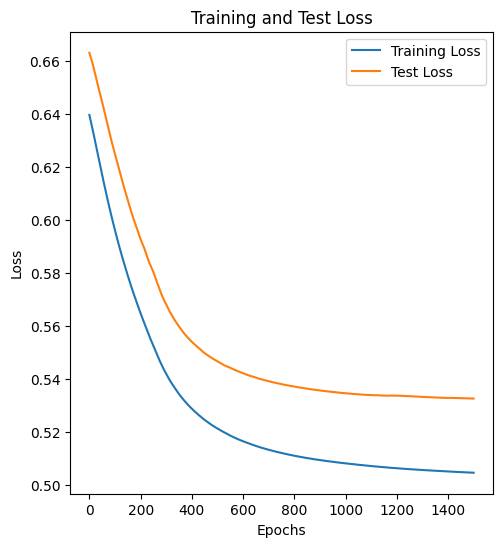

In [19]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

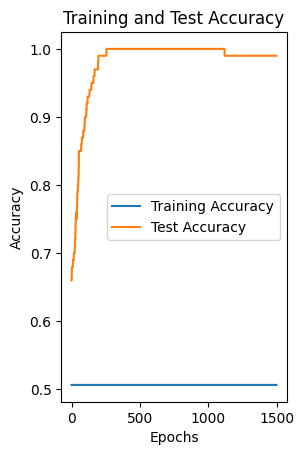

In [20]:
# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.plot(epochs_range, test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.show()

In [21]:
model_0(X_train.to(device,dtype=torch.float))

tensor([[9.9670e-01],
        [9.9793e-01],
        [9.7054e-01],
        [9.9495e-01],
        [1.2101e-04],
        [9.5707e-01],
        [9.9842e-01],
        [9.9699e-01],
        [9.9231e-01],
        [5.5835e-06],
        [9.5541e-01],
        [7.0273e-06],
        [9.6509e-01],
        [9.9591e-01],
        [9.9613e-01],
        [9.9604e-01],
        [3.2902e-03],
        [9.9047e-01],
        [9.8254e-01],
        [6.1939e-04],
        [9.9851e-01],
        [6.6817e-05],
        [7.5876e-03],
        [9.9703e-01],
        [2.3991e-04],
        [1.7019e-03],
        [1.8182e-04],
        [9.9551e-01],
        [9.9201e-01],
        [9.9669e-01],
        [6.5725e-03],
        [5.3007e-06],
        [9.9896e-01],
        [3.7879e-05],
        [3.1385e-04],
        [3.4559e-04],
        [9.7792e-01],
        [9.5134e-01],
        [9.9669e-01],
        [3.4590e-03],
        [5.3434e-04],
        [1.1424e-04],
        [2.6777e-03],
        [9.4508e-01],
        [2.8167e-03],
        [8

In [20]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5533,  1.7944],
                      [-1.1657,  1.4794],
                      [-0.1549,  0.1427],
                      [-1.5139, -0.4783],
                      [-0.0205, -1.7862],
                      [ 1.5811, -1.0594],
                      [ 1.1054,  0.7019],
                      [ 0.3410, -0.0998],
                      [ 1.3423,  0.1747],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.9285, -1.1084, -0.2872, -0.2854, -0.9277, -0.9940, -0.7932, -0.4252,
                      -0.7087, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1003, -0.7695,  0.2441, -0.4521, -0.7198, -0.1744, -0.5442,  0.2555,
                       -0.0098, -0.0997],
                      [ 0.5524,  0.4937,  0.1331,  0.7351,  0.8386,  0.5138,  0.6168,  0.0566,
                        0.3508, -0.1927],
                      [-0.3391, -0.142

In [21]:
train_losses

[array(0.7240512, dtype=float32),
 array(0.7239344, dtype=float32),
 array(0.7238188, dtype=float32),
 array(0.72370434, dtype=float32),
 array(0.7235919, dtype=float32),
 array(0.7234808, dtype=float32),
 array(0.72337204, dtype=float32),
 array(0.72326577, dtype=float32),
 array(0.7231607, dtype=float32),
 array(0.7230557, dtype=float32),
 array(0.7229503, dtype=float32),
 array(0.72284454, dtype=float32),
 array(0.72273797, dtype=float32),
 array(0.7226301, dtype=float32),
 array(0.72252095, dtype=float32),
 array(0.72241086, dtype=float32),
 array(0.7222999, dtype=float32),
 array(0.722188, dtype=float32),
 array(0.7220759, dtype=float32),
 array(0.7219634, dtype=float32),
 array(0.7218507, dtype=float32),
 array(0.7217378, dtype=float32),
 array(0.7216246, dtype=float32),
 array(0.7215111, dtype=float32),
 array(0.7213975, dtype=float32),
 array(0.72128373, dtype=float32),
 array(0.72116965, dtype=float32),
 array(0.72105545, dtype=float32),
 array(0.72094077, dtype=float32),
 arr

In [22]:
loss

tensor(0.5842, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [22]:
test_pred

tensor([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 0., 1., 0., 0.], device='cuda:0')

In [23]:
y_test.cpu() == test_pred.cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True])

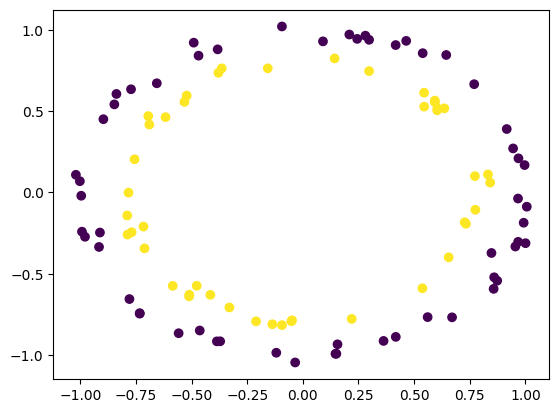

In [24]:
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)

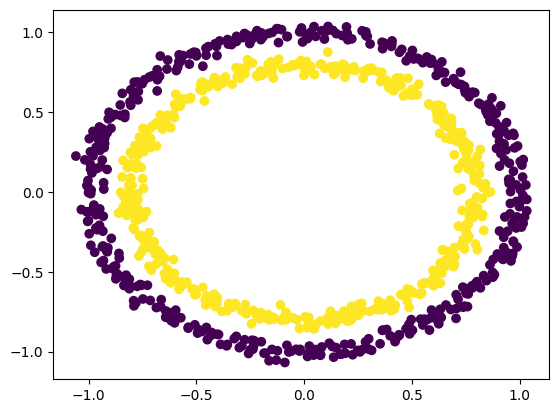

In [25]:

plt.scatter(X_train[:, 0], X_train[:, 1],c=y_train)

In [27]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


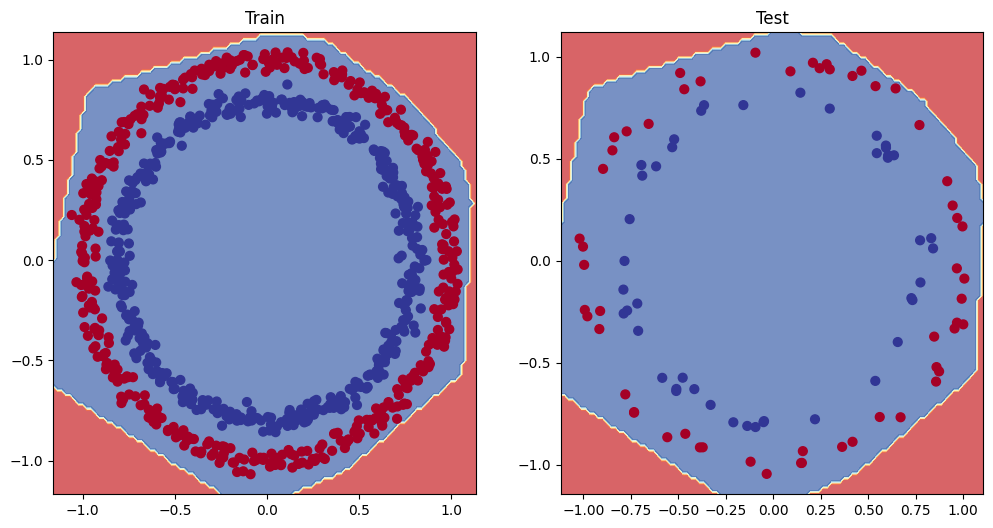

In [28]:
# Plot decision boundaries for training and test sets
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)